In [1]:
import os
import glob
import time
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.ndimage
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_closing, convex_hull_image
from skimage.filters import roberts
from skimage.segmentation import clear_border
import scipy.ndimage as ndi


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# --- MODIFY THESE PATHS ---
LUNA_PATH = '/kaggle/input/luna-16/Dataset' # Base directory of LUNA16 dataset
LUNA_SUBSET_IDS = ['subset0'] # Which subsets to process (e.g., ['subset0', 'subset1'])
LUNA_ANNOTATIONS_CSV = os.path.join(LUNA_PATH, 'annotations.csv')
LUNA_CANDIDATES_CSV = os.path.join(LUNA_PATH, 'candidates.csv')
PREPROCESSED_DATA_PATH = '/kaggle/working/preprocessed_luna/' # Directory to save/load preprocessed numpy arrays

In [3]:
# Ensure output directory exists
os.makedirs(PREPROCESSED_DATA_PATH, exist_ok=True)

# Model & Training Params
TARGET_SPACING = [1, 1, 1] # Target isotropic spacing in mm
PATCH_SIZE = (32, 32, 32) # Input patch size for the CNN (z, y, x)
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 3 # Reduce epochs for quick demo; increase for real training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
print("--- Verifying LUNA16 Data Structure ---")

# Check base path
if not os.path.isdir(LUNA_PATH):
    print(f"ERROR: LUNA16 base path not found: {LUNA_PATH}")
else:
    print(f"LUNA16 base path: {LUNA_PATH}")

    # Check subset folders and MHD files
    subset_paths = [os.path.join(LUNA_PATH, s,s) for s in LUNA_SUBSET_IDS]
    mhd_files = []
    for sp in subset_paths:
        if not os.path.isdir(sp):
            print(f"WARNING: Subset path not found: {sp}")
        else:
            subset_files = glob.glob(os.path.join(sp, "*.mhd"))
            if not subset_files:
                print(f"WARNING: No .mhd files found in subset: {sp}")
            else:
                mhd_files.extend(subset_files)
                print(f"Found {len(subset_files)} MHD files in {sp}")

    if not mhd_files:
        print("ERROR: No MHD files found in specified subsets. Cannot proceed.")
    else:
        print(f"Example MHD file: {mhd_files[0]}")

# Check annotation files
if not os.path.isfile(LUNA_ANNOTATIONS_CSV):
    print(f"ERROR: Annotations CSV not found: {LUNA_ANNOTATIONS_CSV}")
else:
    print(f"Annotations CSV: {LUNA_ANNOTATIONS_CSV}")
    try:
        df_ann = pd.read_csv(LUNA_ANNOTATIONS_CSV)
        print("Annotations CSV loaded successfully. Columns:")
        print(df_ann.columns)
        print(df_ann.head())
    except Exception as e:
        print(f"ERROR: Could not load Annotations CSV: {e}")

if not os.path.isfile(LUNA_CANDIDATES_CSV):
    print(f"ERROR: Candidates CSV not found: {LUNA_CANDIDATES_CSV}")
else:
    print(f"Candidates CSV: {LUNA_CANDIDATES_CSV}")
    try:
        df_cand = pd.read_csv(LUNA_CANDIDATES_CSV)
        print("Candidates CSV loaded successfully. Columns:")
        print(df_cand.columns)
        print(df_cand.head())
    except Exception as e:
        print(f"ERROR: Could not load Candidates CSV: {e}")

print("--- Verification Complete ---")

--- Verifying LUNA16 Data Structure ---
LUNA16 base path: /kaggle/input/luna-16/Dataset
Found 89 MHD files in /kaggle/input/luna-16/Dataset/subset0/subset0
Example MHD file: /kaggle/input/luna-16/Dataset/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
Annotations CSV: /kaggle/input/luna-16/Dataset/annotations.csv
Annotations CSV loaded successfully. Columns:
Index(['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm'], dtype='object')
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387

In [6]:
# --- Loading Function ---
def load_itk(filename):
    """
    Reads a CT scan using SimpleITK.
    Handles potential exceptions during reading.
    Returns image array (z,y,x), origin (z,y,x), spacing (z,y,x).
    """
    try:
        itkimage = sitk.ReadImage(filename)
        image_array = sitk.GetArrayFromImage(itkimage) # z, y, x
        origin = np.array(list(reversed(itkimage.GetOrigin()))) # z, y, x
        spacing = np.array(list(reversed(itkimage.GetSpacing()))) # z, y, x
        return image_array, origin, spacing
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None, None, None

# --- Coordinate Transformation Functions ---
def world_to_voxel(world_coords, origin, spacing):
    """Converts world coordinates (x,y,z) to voxel coordinates (z,y,x)."""
    stretched_voxel_coords = np.absolute(world_coords - origin[::-1]) # Origin is z,y,x -> reverse for world x,y,z
    voxel_coords = stretched_voxel_coords / spacing[::-1] # Spacing is z,y,x -> reverse for world x,y,z
    return np.round(voxel_coords).astype(int)[::-1] # Return as z,y,x

def voxel_to_world(voxel_coords, origin, spacing):
    """Converts voxel coordinates (z,y,x) to world coordinates (x,y,z)."""
    world_coords = (voxel_coords * spacing) + origin
    return world_coords[::-1] # Return as x,y,z

# --- Preprocessing Functions ---

def resample(image, original_spacing, new_spacing=TARGET_SPACING):
    """
    Resamples a 3D image to a new spacing.
    Uses scipy.ndimage.zoom for resampling.
    """
    resize_factor = original_spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    actual_new_spacing = original_spacing / real_resize_factor

    try:
        # Order=1 means bilinear interpolation, Order=0 means nearest neighbor
        # Using nearest neighbor as per the example, but bilinear might be better for intensity
        resampled_image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest', order=0)
        return resampled_image, actual_new_spacing
    except Exception as e:
        print(f"Error during resampling: {e}")
        # Fallback or error handling: return original image?
        # For safety, let's return None to signal failure upstream.
        return None, None


def get_segmented_lungs(im_slice, plot=False):
    """
    Segments the lungs from a single 2D slice based on Hounsfield units and morphology.
    (Adapted from the provided example code)
    Returns the segmented slice.
    """
    # Original implementation used a threshold of -604, common practice uses around -320 for lungs
    # Let's use -320 HU as a threshold for air/lung parenchyma
    THRESHOLD = -320 # Hounsfield Unit threshold

    if plot:
        f, plots = plt.subplots(8, 1, figsize=(5, 40)) # Adjusted number of plots
        plot_nb = 0
        plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Original Slice'); plots[plot_nb].imshow(im_slice, cmap=plt.cm.bone); plot_nb += 1

    # Step 1: Thresholding to create a binary image (air = True)
    binary = im_slice < THRESHOLD
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Thresholded'); plots[plot_nb].imshow(binary, cmap=plt.cm.gray); plot_nb += 1

    # Step 2: Remove blobs connected to the border (likely background air)
    cleared = clear_border(binary)
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Border Cleared'); plots[plot_nb].imshow(cleared, cmap=plt.cm.gray); plot_nb += 1

    # Step 3: Label connected regions
    label_image = label(cleared)
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Labeled Regions'); plots[plot_nb].imshow(label_image, cmap=plt.cm.hot); plot_nb += 1

    # Step 4: Keep the largest regions (presumably the lungs)
    # Keep the two largest regions if possible, otherwise the single largest
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 1:
        threshold_area = areas[-2]
    elif len(areas) == 1:
        threshold_area = areas[-1]
    else:
        threshold_area = 0 # No regions found

    # Filter small regions
    for region in regionprops(label_image):
        if region.area < threshold_area:
            for coordinates in region.coords:
                label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Largest Regions Kept'); plots[plot_nb].imshow(binary, cmap=plt.cm.gray); plot_nb += 1

    # Step 5: Fill holes within the lung regions (using binary_fill_holes)
    # The original code used edge detection + fill holes, which is complex.
    # A simpler approach is morphological closing or direct hole filling.
    # Let's try morphological closing first.
    selem = disk(2) # Small disk for closing fine structures
    binary = binary_closing(binary, selem)
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Morphological Closing'); plots[plot_nb].imshow(binary, cmap=plt.cm.gray); plot_nb += 1

    # Step 6: Optional - Convex Hull (can sometimes include non-lung areas)
    # Omit convex hull from original example as it can be too aggressive
    # final_mask = convex_hull_image(binary) # Optional

    # Step 7: Dilate mask slightly to include nodules potentially attached to the pleura/wall
    selem_dilate = disk(5) # Dilate by 5 pixels (adjust as needed)
    final_mask = ndi.binary_dilation(binary, structure=selem_dilate)
    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Final Mask (Dilated)'); plots[plot_nb].imshow(final_mask, cmap=plt.cm.gray); plot_nb += 1


    # Step 8: Apply mask to original image
    segmented_slice = im_slice.copy()
    segmented_slice[final_mask == 0] = -2000 # Set background to a low HU value (outside typical lung range)

    if plot: plots[plot_nb].axis('off'); plots[plot_nb].set_title(f'{plot_nb}: Segmented Slice'); plots[plot_nb].imshow(segmented_slice, cmap=plt.cm.bone); plot_nb += 1


    return segmented_slice, final_mask


def normalize_hu(image):
    """Normalizes Hounsfield Units (HU) to the range [0, 1]."""
    MIN_BOUND = -1000.0 # Lower bound for HU relevant for lung nodules
    MAX_BOUND = 400.0  # Upper bound for HU
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def zero_center(image):
    """Zero-centers the normalized image."""
    # Assuming normalization produced range [0,1]
    PIXEL_MEAN = 0.25 # Approximate mean value for normalized lung CTs
    image = image - PIXEL_MEAN
    return image

In [7]:
# --- Full Preprocessing Pipeline Function ---
def preprocess_scan(mhd_file_path, output_path_base, force_preprocess=False):
    """
    Loads, preprocesses (resample, segment, normalize, zero-center),
    and saves a CT scan. Returns the processed image array and metadata.
    Checks if preprocessed file exists to avoid re-computation.
    """
    seriesuid = os.path.basename(mhd_file_path).replace('.mhd', '')
    output_filename = os.path.join(output_path_base, f"{seriesuid}.npz")

    if os.path.exists(output_filename) and not force_preprocess:
        print(f"Loading preprocessed file: {output_filename}")
        try:
            npz_data = np.load(output_filename)
            return (npz_data['image'],
                    npz_data['origin'],
                    npz_data['spacing'],
                    npz_data['lung_mask'])
        except Exception as e:
            print(f"Error loading {output_filename}, will re-preprocess. Error: {e}")

    print(f"Processing scan: {seriesuid}")
    # 1. Load Scan
    image, origin, spacing = load_itk(mhd_file_path)
    if image is None:
        print(f"Failed to load {seriesuid}. Skipping.")
        return None, None, None, None
    print(f"  Original shape: {image.shape}, spacing: {spacing}")

    # 2. Resample to target spacing
    resampled_image, new_spacing = resample(image, spacing, TARGET_SPACING)
    if resampled_image is None:
        print(f"Failed to resample {seriesuid}. Skipping.")
        return None, None, None, None
    print(f"  Resampled shape: {resampled_image.shape}, new spacing: {new_spacing}")

    # 3. Segment Lungs (slice by slice)
    print("  Segmenting lungs...")
    segmented_lungs = np.zeros_like(resampled_image)
    lung_mask = np.zeros_like(resampled_image, dtype=bool)
    for i in tqdm(range(resampled_image.shape[0]), desc=f"  Slicing {seriesuid}", leave=False):
        segmented_slice, mask_slice = get_segmented_lungs(resampled_image[i])
        segmented_lungs[i] = segmented_slice
        lung_mask[i] = mask_slice

    # 4. Normalize HU
    normalized_image = normalize_hu(segmented_lungs)

    # 5. Zero Center
    final_image = zero_center(normalized_image)
    print(f"  Final image dtype before save: {final_image.dtype}")
    # --- CONVERT TO float32 BEFORE SAVING ---
    final_image_float32 = final_image.astype(np.float32)
    lung_mask_bool = lung_mask.astype(bool) # Ensure mask is boolean
    print(f"  Final image dtype AFTER conversion: {final_image_float32.dtype}")

    # 6. Save preprocessed data
    try:
        np.savez_compressed(output_filename,
                        image=final_image_float32,  # <<< Use the float32 version
                        origin=origin,
                        spacing=new_spacing,
                        lung_mask=lung_mask_bool)
        print(f"  Saved preprocessed data (float32) to {output_filename}")
    except Exception as e:
        print(f"Error saving preprocessed data for {seriesuid}: {e}")

    return final_image, origin, new_spacing, lung_mask

In [8]:
# --- Load Annotations ---
try:
    annotations_df = pd.read_csv(LUNA_ANNOTATIONS_CSV)
    candidates_df = pd.read_csv(LUNA_CANDIDATES_CSV)
    print(f"Loaded {len(annotations_df)} annotations and {len(candidates_df)} candidates.")
except Exception as e:
    print(f"ERROR: Failed to load annotation/candidate CSVs: {e}")
    # Stop execution if annotations are missing
    raise SystemExit("Cannot proceed without annotation files.")

Loaded 1186 annotations and 551065 candidates.


In [9]:
# --- Collect all MHD file paths ---
all_mhd_files = []
for subset_id in LUNA_SUBSET_IDS:
    subset_path = os.path.join(LUNA_PATH, subset_id,subset_id)
    mhd_files = glob.glob(os.path.join(subset_path, "*.mhd"))
    all_mhd_files.extend(mhd_files)

print(f"Found {len(all_mhd_files)} total MHD files to process in subsets: {LUNA_SUBSET_IDS}")

Found 89 total MHD files to process in subsets: ['subset0']


In [10]:
# --- Preprocess all scans ---
# This dictionary will store metadata for processed scans
processed_scan_data = {}

start_time = time.time()
for mhd_file in tqdm(all_mhd_files, desc="Preprocessing Scans"):
    seriesuid = os.path.basename(mhd_file).replace('.mhd', '')
    image, origin, spacing, mask = preprocess_scan(mhd_file, PREPROCESSED_DATA_PATH)
    if image is not None:
        processed_scan_data[seriesuid] = {
            'path': os.path.join(PREPROCESSED_DATA_PATH, f"{seriesuid}.npz"),
            'original_origin': origin, # Keep original origin for coord conversion
            'resampled_spacing': spacing,
            'resampled_shape': image.shape
        }
    else:
        print(f"Skipping {seriesuid} due to processing errors.")

end_time = time.time()
print(f"\nPreprocessing finished in {end_time - start_time:.2f} seconds.")
print(f"Successfully processed {len(processed_scan_data)} scans.")

# Filter annotations and candidates to only include successfully processed scans
processed_seriesuids = list(processed_scan_data.keys())
annotations_df = annotations_df[annotations_df['seriesuid'].isin(processed_seriesuids)].copy()
candidates_df = candidates_df[candidates_df['seriesuid'].isin(processed_seriesuids)].copy()

print(f"Filtered annotations: {len(annotations_df)} entries")
print(f"Filtered candidates: {len(candidates_df)} entries")

Preprocessing Scans:   0%|          | 0/89 [00:00<?, ?it/s]

Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523
  Original shape: (232, 512, 512), spacing: [1.25     0.703125 0.703125]
  Resampled shape: (290, 360, 360), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523:   0%|          | 0/290 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732
  Original shape: (297, 512, 512), spacing: [1.25       0.94921899 0.94921899]
  Resampled shape: (371, 486, 486), new spacing: [1.00067385 1.00000025 1.00000025]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732:   0%|          | 0/371 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912
  Original shape: (133, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (332, 360, 360), new spacing: [1.00150602 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879
  Original shape: (124, 512, 512), spacing: [2.5        0.59960902 0.59960902]
  Resampled shape: (310, 307, 307), new spacing: [1.        0.9999994 0.9999994]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879:   0%|          | 0/310 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223
  Original shape: (209, 512, 512), spacing: [1.25       0.69335902 0.69335902]
  Resampled shape: (261, 355, 355), new spacing: [1.00095785 0.99999948 0.99999948]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223:   0%|          | 0/261 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998
  Original shape: (133, 512, 512), spacing: [2.5      0.859375 0.859375]
  Resampled shape: (332, 440, 440), new spacing: [1.00150602 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547
  Original shape: (545, 512, 512), spacing: [0.625      0.72265601 0.72265601]
  Resampled shape: (341, 370, 370), new spacing: [0.99890029 0.99999967 0.99999967]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547:   0%|          | 0/341 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986
  Original shape: (221, 512, 512), spacing: [1.25       0.62109399 0.62109399]
  Resampled shape: (276, 318, 318), new spacing: [1.0009058  1.00000038 1.00000038]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986:   0%|          | 0/276 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097
  Original shape: (246, 512, 512), spacing: [1.        0.7421875 0.7421875]
  Resampled shape: (246, 380, 380), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097:   0%|          | 0/246 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227
  Original shape: (275, 512, 512), spacing: [1.      0.78125 0.78125]
  Resampled shape: (275, 400, 400), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227:   0%|          | 0/275 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730
  Original shape: (481, 512, 512), spacing: [0.625      0.60546899 0.60546899]
  Resampled shape: (301, 310, 310), new spacing: [0.99875415 1.00000039 1.00000039]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730:   0%|          | 0/301 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359
  Original shape: (267, 512, 512), spacing: [1.25       0.59570301 0.59570301]
  Resampled shape: (334, 305, 305), new spacing: [0.9992515 0.9999998 0.9999998]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359:   0%|          | 0/334 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490
  Original shape: (465, 512, 512), spacing: [0.625    0.703125 0.703125]
  Resampled shape: (291, 360, 360), new spacing: [0.99871134 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490:   0%|          | 0/291 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896
  Original shape: (229, 512, 512), spacing: [1.25       0.65429699 0.65429699]
  Resampled shape: (286, 335, 335), new spacing: [1.00087413 1.00000018 1.00000018]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896:   0%|          | 0/286 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874
  Original shape: (325, 512, 512), spacing: [1.      0.78125 0.78125]
  Resampled shape: (325, 400, 400), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874:   0%|          | 0/325 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410
  Original shape: (733, 512, 512), spacing: [0.5        0.63671875 0.63671875]
  Resampled shape: (366, 326, 326), new spacing: [1.00136612 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410:   0%|          | 0/366 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176
  Original shape: (127, 512, 512), spacing: [2.5        0.58593798 0.58593798]
  Resampled shape: (318, 300, 300), new spacing: [0.99842767 1.00000081 1.00000081]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176:   0%|          | 0/318 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260
  Original shape: (121, 512, 512), spacing: [2.5        0.76171899 0.76171899]
  Resampled shape: (302, 390, 390), new spacing: [1.00165563 1.00000031 1.00000031]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260:   0%|          | 0/302 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441
  Original shape: (197, 512, 512), spacing: [1.25     0.859375 0.859375]
  Resampled shape: (246, 440, 440), new spacing: [1.00101626 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441:   0%|          | 0/246 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281
  Original shape: (516, 512, 512), spacing: [0.625      0.82031202 0.82031202]
  Resampled shape: (322, 420, 420), new spacing: [1.0015528  0.99999942 0.99999942]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281:   0%|          | 0/322 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
  Original shape: (280, 512, 512), spacing: [1.         0.57226562 0.57226562]
  Resampled shape: (280, 293, 293), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991
  Original shape: (129, 512, 512), spacing: [2.5     0.78125 0.78125]
  Resampled shape: (322, 400, 400), new spacing: [1.0015528 1.        1.       ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991:   0%|          | 0/322 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860
  Original shape: (123, 512, 512), spacing: [2.5        0.61718798 0.61718798]
  Resampled shape: (308, 316, 316), new spacing: [0.99837662 1.00000077 1.00000077]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860:   0%|          | 0/308 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059
  Original shape: (161, 512, 512), spacing: [1.25       0.54882801 0.54882801]
  Resampled shape: (201, 281, 281), new spacing: [1.00124378 0.99999978 0.99999978]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059:   0%|          | 0/201 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768
  Original shape: (204, 512, 512), spacing: [1.79999995 0.64453125 0.64453125]
  Resampled shape: (367, 330, 330), new spacing: [1.00054493 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768:   0%|          | 0/367 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114
  Original shape: (127, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (318, 360, 360), new spacing: [0.99842767 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114:   0%|          | 0/318 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367
  Original shape: (325, 512, 512), spacing: [1.         0.61132812 0.61132812]
  Resampled shape: (325, 313, 313), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367:   0%|          | 0/325 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543
  Original shape: (280, 512, 512), spacing: [1.       0.578125 0.578125]
  Resampled shape: (280, 296, 296), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729
  Original shape: (280, 512, 512), spacing: [1.         0.61328125 0.61328125]
  Resampled shape: (280, 314, 314), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005
  Original shape: (280, 512, 512), spacing: [1.00000012 0.67578125 0.67578125]
  Resampled shape: (280, 346, 346), new spacing: [1.00000012 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565
  Original shape: (195, 512, 512), spacing: [1.79999995 0.72265625 0.72265625]
  Resampled shape: (351, 370, 370), new spacing: [0.99999997 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565:   0%|          | 0/351 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843
  Original shape: (274, 512, 512), spacing: [1.25       0.61523402 0.61523402]
  Resampled shape: (342, 315, 315), new spacing: [1.00146199 0.99999942 0.99999942]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843:   0%|          | 0/342 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820
  Original shape: (730, 512, 512), spacing: [0.5        0.73046875 0.73046875]
  Resampled shape: (365, 374, 374), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820:   0%|          | 0/365 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733
  Original shape: (123, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (308, 360, 360), new spacing: [0.99837662 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733:   0%|          | 0/308 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526
  Original shape: (140, 512, 512), spacing: [2.5        0.72265601 0.72265601]
  Resampled shape: (350, 370, 370), new spacing: [1.         0.99999967 0.99999967]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526:   0%|          | 0/350 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767
  Original shape: (471, 512, 512), spacing: [0.625      0.58593798 0.58593798]
  Resampled shape: (294, 300, 300), new spacing: [1.00127551 1.00000081 1.00000081]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767:   0%|          | 0/294 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987
  Original shape: (538, 512, 512), spacing: [0.625      0.74218798 0.74218798]
  Resampled shape: (336, 380, 380), new spacing: [1.00074405 1.00000064 1.00000064]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987:   0%|          | 0/336 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780
  Original shape: (404, 512, 512), spacing: [0.625    0.703125 0.703125]
  Resampled shape: (252, 360, 360), new spacing: [1.00198413 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780:   0%|          | 0/252 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718
  Original shape: (151, 512, 512), spacing: [2.5      0.859375 0.859375]
  Resampled shape: (378, 440, 440), new spacing: [0.99867725 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718:   0%|          | 0/378 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827
  Original shape: (369, 512, 512), spacing: [0.625    0.703125 0.703125]
  Resampled shape: (231, 360, 360), new spacing: [0.99837662 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827:   0%|          | 0/231 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509
  Original shape: (157, 512, 512), spacing: [2.         0.66406202 0.66406202]
  Resampled shape: (314, 340, 340), new spacing: [1.         0.99999928 0.99999928]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509:   0%|          | 0/314 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
  Original shape: (195, 512, 512), spacing: [1.79999995 0.7421875  0.7421875 ]
  Resampled shape: (351, 380, 380), new spacing: [0.99999997 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326:   0%|          | 0/351 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488
  Original shape: (139, 512, 512), spacing: [2.5     0.78125 0.78125]
  Resampled shape: (348, 400, 400), new spacing: [0.99856322 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488:   0%|          | 0/348 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514
  Original shape: (133, 512, 512), spacing: [2.5        0.55664098 0.55664098]
  Resampled shape: (332, 285, 285), new spacing: [1.00150602 1.00000064 1.00000064]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179
  Original shape: (141, 512, 512), spacing: [2.5   0.625 0.625]
  Resampled shape: (352, 320, 320), new spacing: [1.00142045 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/352 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196
  Original shape: (133, 512, 512), spacing: [2.5        0.97656202 0.97656202]
  Resampled shape: (332, 500, 500), new spacing: [1.00150602 0.99999951 0.99999951]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058
  Original shape: (140, 512, 512), spacing: [2.         0.66406202 0.66406202]
  Resampled shape: (280, 340, 340), new spacing: [1.         0.99999928 0.99999928]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596
  Original shape: (474, 512, 512), spacing: [0.625 0.625 0.625]
  Resampled shape: (296, 320, 320), new spacing: [1.00084459 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596:   0%|          | 0/296 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682
  Original shape: (117, 512, 512), spacing: [2.5        0.66406202 0.66406202]
  Resampled shape: (292, 340, 340), new spacing: [1.00171233 0.99999928 0.99999928]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682:   0%|          | 0/292 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037
  Original shape: (290, 512, 512), spacing: [1.         0.68164062 0.68164062]
  Resampled shape: (290, 349, 349), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037:   0%|          | 0/290 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371
  Original shape: (133, 512, 512), spacing: [2.5        0.82031202 0.82031202]
  Resampled shape: (332, 420, 420), new spacing: [1.00150602 0.99999942 0.99999942]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
  Original shape: (157, 512, 512), spacing: [2.       0.703125 0.703125]
  Resampled shape: (314, 360, 360), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321:   0%|          | 0/314 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231
  Original shape: (177, 512, 512), spacing: [1.79999995 0.7421875  0.7421875 ]
  Resampled shape: (319, 380, 380), new spacing: [0.99874606 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231:   0%|          | 0/319 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963
  Original shape: (194, 512, 512), spacing: [1.79999995 0.68359375 0.68359375]
  Resampled shape: (349, 350, 350), new spacing: [1.00057304 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963:   0%|          | 0/349 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843
  Original shape: (141, 512, 512), spacing: [2.5        0.82031202 0.82031202]
  Resampled shape: (352, 420, 420), new spacing: [1.00142045 0.99999942 0.99999942]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843:   0%|          | 0/352 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345
  Original shape: (392, 512, 512), spacing: [0.75       0.63867188 0.63867188]
  Resampled shape: (294, 327, 327), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345:   0%|          | 0/294 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845
  Original shape: (127, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (318, 360, 360), new spacing: [0.99842767 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845:   0%|          | 0/318 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663
  Original shape: (244, 512, 512), spacing: [1.24999988 0.52539098 0.52539098]
  Resampled shape: (305, 269, 269), new spacing: [0.9999999  1.00000068 1.00000068]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663:   0%|          | 0/305 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574
  Original shape: (429, 512, 512), spacing: [0.69999999 0.53710938 0.53710938]
  Resampled shape: (300, 275, 275), new spacing: [1.00099998 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574:   0%|          | 0/300 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831
  Original shape: (477, 512, 512), spacing: [0.625   0.78125 0.78125]
  Resampled shape: (298, 400, 400), new spacing: [1.00041946 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831:   0%|          | 0/298 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865
  Original shape: (280, 512, 512), spacing: [1.        0.7109375 0.7109375]
  Resampled shape: (280, 364, 364), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865:   0%|          | 0/280 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668
  Original shape: (483, 512, 512), spacing: [0.69999999 0.65234375 0.65234375]
  Resampled shape: (338, 334, 334), new spacing: [1.00029584 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668:   0%|          | 0/338 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492
  Original shape: (119, 512, 512), spacing: [2.5        0.74218798 0.74218798]
  Resampled shape: (298, 380, 380), new spacing: [0.99832215 1.00000064 1.00000064]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492:   0%|          | 0/298 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273
  Original shape: (147, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (368, 360, 360), new spacing: [0.9986413 1.        1.       ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273:   0%|          | 0/368 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720
  Original shape: (124, 512, 512), spacing: [2.5        0.61523402 0.61523402]
  Resampled shape: (310, 315, 315), new spacing: [1.         0.99999942 0.99999942]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720:   0%|          | 0/310 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495
  Original shape: (300, 512, 512), spacing: [1.         0.74414062 0.74414062]
  Resampled shape: (300, 381, 381), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495:   0%|          | 0/300 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112
  Original shape: (109, 512, 512), spacing: [2.5     0.78125 0.78125]
  Resampled shape: (272, 400, 400), new spacing: [1.00183824 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112:   0%|          | 0/272 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235
  Original shape: (152, 512, 512), spacing: [2.5     0.78125 0.78125]
  Resampled shape: (380, 400, 400), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235:   0%|          | 0/380 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074
  Original shape: (276, 512, 512), spacing: [1.        0.6171875 0.6171875]
  Resampled shape: (276, 316, 316), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074:   0%|          | 0/276 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686
  Original shape: (295, 512, 512), spacing: [1.         0.68164062 0.68164062]
  Resampled shape: (295, 349, 349), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686:   0%|          | 0/295 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145
  Original shape: (129, 512, 512), spacing: [2.5        0.64453101 0.64453101]
  Resampled shape: (322, 330, 330), new spacing: [1.0015528  0.99999963 0.99999963]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145:   0%|          | 0/322 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975
  Original shape: (133, 512, 512), spacing: [2.5        0.74218798 0.74218798]
  Resampled shape: (332, 380, 380), new spacing: [1.00150602 1.00000064 1.00000064]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975:   0%|          | 0/332 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748
  Original shape: (125, 512, 512), spacing: [2.5      0.703125 0.703125]
  Resampled shape: (312, 360, 360), new spacing: [1.00160256 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748:   0%|          | 0/312 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734
  Original shape: (246, 512, 512), spacing: [1.25     0.859375 0.859375]
  Resampled shape: (308, 440, 440), new spacing: [0.99837662 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734:   0%|          | 0/308 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517
  Original shape: (250, 512, 512), spacing: [1.25       0.65429699 0.65429699]
  Resampled shape: (312, 335, 335), new spacing: [1.00160256 1.00000018 1.00000018]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517:   0%|          | 0/312 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493
  Original shape: (147, 512, 512), spacing: [2.5        0.74218798 0.74218798]
  Resampled shape: (368, 380, 380), new spacing: [0.9986413  1.00000064 1.00000064]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493:   0%|          | 0/368 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484
  Original shape: (176, 512, 512), spacing: [1.79999995 0.5859375  0.5859375 ]
  Resampled shape: (317, 300, 300), new spacing: [0.99936906 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484:   0%|          | 0/317 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952
  Original shape: (245, 512, 512), spacing: [1.      0.78125 0.78125]
  Resampled shape: (245, 400, 400), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952:   0%|          | 0/245 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304
  Original shape: (255, 512, 512), spacing: [1.25       0.65429699 0.65429699]
  Resampled shape: (319, 335, 335), new spacing: [0.9992163  1.00000018 1.00000018]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304:   0%|          | 0/319 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430
  Original shape: (139, 512, 512), spacing: [2.5     0.78125 0.78125]
  Resampled shape: (348, 400, 400), new spacing: [0.99856322 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430:   0%|          | 0/348 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950
  Original shape: (483, 512, 512), spacing: [0.69999999 0.6171875  0.6171875 ]
  Resampled shape: (338, 316, 316), new spacing: [1.00029584 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950:   0%|          | 0/338 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411
  Original shape: (588, 512, 512), spacing: [0.5        0.51367188 0.51367188]
  Resampled shape: (294, 263, 263), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411:   0%|          | 0/294 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557
  Original shape: (265, 512, 512), spacing: [1.25       0.94335902 0.94335902]
  Resampled shape: (331, 483, 483), new spacing: [1.00075529 0.99999962 0.99999962]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557:   0%|          | 0/331 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111
  Original shape: (250, 512, 512), spacing: [1.25       0.58593798 0.58593798]
  Resampled shape: (312, 300, 300), new spacing: [1.00160256 1.00000081 1.00000081]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111:   0%|          | 0/312 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444
  Original shape: (200, 512, 512), spacing: [1.        0.5234375 0.5234375]
  Resampled shape: (200, 268, 268), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444:   0%|          | 0/200 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830
  Original shape: (129, 512, 512), spacing: [2.5        0.69726598 0.69726598]
  Resampled shape: (322, 357, 357), new spacing: [1.0015528  1.00000051 1.00000051]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830:   0%|          | 0/322 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574
  Original shape: (183, 512, 512), spacing: [1.79999995 0.6640625  0.6640625 ]
  Resampled shape: (329, 340, 340), new spacing: [1.00121578 1.         1.        ]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574:   0%|          | 0/329 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354
  Original shape: (672, 512, 512), spacing: [0.5        0.60742188 0.60742188]
  Resampled shape: (336, 311, 311), new spacing: [1. 1. 1.]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354:   0%|          | 0/336 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.npz
Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056
  Original shape: (120, 512, 512), spacing: [2.5        0.64453101 0.64453101]
  Resampled shape: (300, 330, 330), new spacing: [1.         0.99999963 0.99999963]
  Segmenting lungs...


  Slicing 1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056:   0%|          | 0/300 [00:00<?, ?…

  Final image dtype before save: float64
  Final image dtype AFTER conversion: float32
  Saved preprocessed data (float32) to /kaggle/working/preprocessed_luna/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.npz

Preprocessing finished in 1278.12 seconds.
Successfully processed 89 scans.
Filtered annotations: 112 entries
Filtered candidates: 56938 entries


In [11]:

# ## 6. Dataset and Dataloader Definition

# In[5]:


# --- Patch Extraction Function ---
def extract_patch(image, center_voxel, patch_size):
    """
    Extracts a 3D patch from an image centered at center_voxel.
    Handles boundary conditions by padding with the minimum value of the image.
    Args:
        image (np.ndarray): The 3D image (z, y, x).
        center_voxel (tuple): The center coordinates in voxel space (z, y, x).
        patch_size (tuple): The desired patch size (depth, height, width).
    Returns:
        np.ndarray: The extracted patch, or None if extraction fails.
    """
    patch_z, patch_y, patch_x = patch_size
    center_z, center_y, center_x = center_voxel

    # Calculate start and end indices for each dimension
    start_z = center_z - patch_z // 2
    end_z = start_z + patch_z
    start_y = center_y - patch_y // 2
    end_y = start_y + patch_y
    start_x = center_x - patch_x // 2
    end_x = start_x + patch_x

    # Determine padding needed
    pad_z_before = max(0, -start_z)
    pad_z_after = max(0, end_z - image.shape[0])
    pad_y_before = max(0, -start_y)
    pad_y_after = max(0, end_y - image.shape[1])
    pad_x_before = max(0, -start_x)
    pad_x_after = max(0, end_x - image.shape[2])

    # Adjust slice indices based on padding
    slice_start_z = max(0, start_z)
    slice_end_z = min(image.shape[0], end_z)
    slice_start_y = max(0, start_y)
    slice_end_y = min(image.shape[1], end_y)
    slice_start_x = max(0, start_x)
    slice_end_x = min(image.shape[2], end_x)

    # Extract the valid part of the patch
    patch = image[slice_start_z:slice_end_z, slice_start_y:slice_end_y, slice_start_x:slice_end_x]

    # Pad if necessary
    if any([pad_z_before, pad_z_after, pad_y_before, pad_y_after, pad_x_before, pad_x_after]):
        # Use a value representative of background/outside scan area after normalization/centering
        pad_value = image.min() # Use the minimum value of the input image for padding
        pad_width = (
            (pad_z_before, pad_z_after),
            (pad_y_before, pad_y_after),
            (pad_x_before, pad_x_after)
        )
        try:
            patch = np.pad(patch, pad_width, mode='constant', constant_values=pad_value)
        except Exception as e:
            print(f"Error during padding: {e}")
            print(f"Shape before padding: {patch.shape}, Pad width: {pad_width}")
            return None # Return None if padding fails

    # Final check for patch size consistency
    if patch.shape != patch_size:
         # This can happen if the nodule center calculation or slicing logic is flawed
         print(f"Warning: Extracted patch shape {patch.shape} does not match target {patch_size}. Center: {center_voxel}, Image shape: {image.shape}")
         # Attempt to resize or return None? Returning None might be safer.
         return None


    return patch


In [12]:

# --- Nodule Candidate Dataset Class ---
class NoduleDetectionDataset(Dataset):
    def __init__(self, candidates_info, processed_scan_data, patch_size):
        """
        Args:
            candidates_info (list): List of dictionaries, each containing 'seriesuid',
                                   'voxel_coord' (z,y,x), 'label' (0 or 1), 'diameter_mm'.
            processed_scan_data (dict): Dictionary mapping seriesuid to scan metadata
                                        (path, original_origin, resampled_spacing, resampled_shape).
            patch_size (tuple): Size of the patch to extract (depth, height, width).
        """
        self.candidates_info = candidates_info
        self.processed_scan_data = processed_scan_data
        self.patch_size = patch_size
        self.loaded_scans = {} # Cache for loaded numpy arrays

    def __len__(self):
        return len(self.candidates_info)

    def __getitem__(self, idx):
        candidate = self.candidates_info[idx]
        seriesuid = candidate['seriesuid']
        center_voxel = candidate['voxel_coord']
        label = candidate['label']

        # Load the preprocessed scan data (if not already cached)
        if seriesuid not in self.loaded_scans:
            scan_path = self.processed_scan_data[seriesuid]['path']
            try:
                npz_data = np.load(scan_path)
                self.loaded_scans[seriesuid] = npz_data['image']
                # Optional: Free up memory if caching too much
                # if len(self.loaded_scans) > MAX_CACHE_SIZE: ...
            except Exception as e:
                print(f"Error loading scan {seriesuid} from {scan_path}: {e}")
                # Return dummy data or raise error? For now, skip this sample.
                # To make it runnable, let's return a dummy tensor and label
                dummy_patch = torch.zeros((1, *self.patch_size), dtype=torch.float32)
                return dummy_patch, torch.tensor(-1, dtype=torch.float32) # Use -1 label to indicate error


        image = self.loaded_scans[seriesuid]

        # Extract the patch
        patch = extract_patch(image, center_voxel, self.patch_size)

        if patch is None:
            # Handle patch extraction failure (e.g., due to coordinate issues)
            print(f"Failed to extract patch for candidate {idx} (Series: {seriesuid}, Center: {center_voxel})")
            dummy_patch = torch.zeros((1, *self.patch_size), dtype=torch.float32)
            return dummy_patch, torch.tensor(-1, dtype=torch.float32) # Use -1 label

        # Convert patch to PyTorch tensor (add channel dimension)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0) # Shape: (1, D, H, W)
        label_tensor = torch.tensor(label, dtype=torch.float32) # Use float for BCEWithLogitsLoss

        return patch_tensor, label_tensor


In [13]:
# In Cell [5] - Corrected loop for positive samples

# --- Prepare Candidate List for Dataset ---
candidate_list_for_dataset = []
processed_count = 0 # Add a counter

# 1. Add Positive Samples (True Nodules)
print("Processing positive samples (annotations)...")
for _, row in tqdm(annotations_df.iterrows(), total=len(annotations_df), desc="Annotations"):
    seriesuid = row['seriesuid']
    if seriesuid in processed_scan_data:
        world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
        meta = processed_scan_data[seriesuid] # Get the dictionary for this UID

        # --- Get ALL necessary metadata ---
        original_origin = meta['original_origin']
        resampled_spacing = meta['resampled_spacing']
        resampled_shape = meta['resampled_shape'] # <<< FIX: Assign resampled_shape here

        # Check coordinate conversion AND bounds in one go
        try:
            # Optional: You can remove the print statements now if desired
            # print(f"\nProcessing Annotation: seriesuid={seriesuid}")
            # print(f"  World Coords: {world_coord}")
            # print(f"  Original Origin: {original_origin}")
            # print(f"  Resampled Spacing: {resampled_spacing}")
            # print(f"  Resampled Shape: {resampled_shape}") # Good to keep this one for debugging bounds

            voxel_coord = world_to_voxel(world_coord, original_origin, resampled_spacing)
            # print(f"  Calculated Voxel Coords (z,y,x): {voxel_coord}")

            # Check if voxel coords are within the valid range of the resampled image array
            if not (0 <= voxel_coord[0] < resampled_shape[0] and \
                    0 <= voxel_coord[1] < resampled_shape[1] and \
                    0 <= voxel_coord[2] < resampled_shape[2]):
                 # print(f"  Warning: Nodule {seriesuid} @ Voxel {voxel_coord} outside resampled bounds {resampled_shape}. Skipping.") # Keep commented unless needed
                 continue # Skip this annotation row

            # ---- If all checks pass, append ----
            candidate_list_for_dataset.append({
                'seriesuid': seriesuid,
                'voxel_coord': tuple(voxel_coord), # (z, y, x)
                'label': 1, # Positive class
                'diameter_mm': row['diameter_mm']
            })
            processed_count += 1 # Increment counter

        except Exception as e:
             # This will now catch errors other than the NameError if they occur
             print(f"  Error processing annotation for {seriesuid} (after NameError fix): {e}")
             continue # Skip on error
    # else: # Optional debug for scans not found
        # print(f"Skipping seriesuid {seriesuid} - not found in processed_scan_data")


# Update the print statement and num_positive calculation
print(f"Added {processed_count} positive samples.")
num_positive = processed_count # Use the actual count for negative sampling ratio

# --- Code for adding Negative Samples follows ---
# ... (rest of the cell) ...

Processing positive samples (annotations)...


Annotations:   0%|          | 0/112 [00:00<?, ?it/s]

Added 112 positive samples.


In [14]:
# 2. Add Negative Samples (From candidates.csv where class=0)
print("Processing negative samples (candidates class=0)...")
negative_processed_count = 0 # Counter for successfully added negative samples

if num_positive > 0: # Only add negatives if we have positives to balance against
    # Balance the dataset: Add similar number of negatives as positives, or apply ratio
    # Example: Aim for 1:2 positive:negative ratio, but adjust if few positives found
    # Ensure we don't request more negatives than available.
    num_negative_to_add = min(num_positive * 2, len(candidates_df[candidates_df['class'] == 0]))

    negative_candidates = candidates_df[candidates_df['class'] == 0]
    # Optional: Stratify sampling across scans if needed
    # Ensure n is not negative or zero if num_negative_to_add ended up <= 0
    if num_negative_to_add > 0:
        negative_candidates = negative_candidates.sample(n=num_negative_to_add, random_state=SEED)
        print(f"Attempting to add {num_negative_to_add} negative samples.")

        for _, row in tqdm(negative_candidates.iterrows(), total=len(negative_candidates), desc="Negative Candidates"):
            seriesuid = row['seriesuid']
            # No need to check if seriesuid in processed_scan_data again, already filtered candidates_df
            world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
            meta = processed_scan_data[seriesuid]
            original_origin = meta['original_origin']
            resampled_spacing = meta['resampled_spacing']
            resampled_shape = meta['resampled_shape']

            try:
                voxel_coord = world_to_voxel(world_coord, original_origin, resampled_spacing)

                # Sanity check voxel coordinates against resampled shape
                if not (0 <= voxel_coord[0] < resampled_shape[0] and \
                        0 <= voxel_coord[1] < resampled_shape[1] and \
                        0 <= voxel_coord[2] < resampled_shape[2]):
                     # print(f"Warning: Negative candidate {seriesuid} @ Voxel {voxel_coord} outside bounds {resampled_shape}. Skipping.")
                     continue # Silently skip negatives outside bounds

                candidate_list_for_dataset.append({
                    'seriesuid': seriesuid,
                    'voxel_coord': tuple(voxel_coord), # (z, y, x)
                    'label': 0, # Negative class
                    'diameter_mm': 0 # Placeholder
                })
                negative_processed_count += 1
            except Exception as e:
                 print(f"  Error processing negative candidate for {seriesuid}: {e}")
                 continue # Skip on error
    else:
         print("No negative samples requested as num_positive * 2 <= 0 or no negative candidates available.")

else:
    print("Skipping negative samples as no positive samples were added.")


print(f"Added {negative_processed_count} negative samples.")
print(f"Total samples for dataset: {len(candidate_list_for_dataset)}")

Processing negative samples (candidates class=0)...
Attempting to add 224 negative samples.


Negative Candidates:   0%|          | 0/224 [00:00<?, ?it/s]

Added 224 negative samples.
Total samples for dataset: 336


In [15]:
print("\n--- Debugging Data Availability ---")
annotated_uids = set(annotations_df['seriesuid'].unique())
processed_uids = set(processed_scan_data.keys())
overlap_uids = annotated_uids.intersection(processed_uids)
print(f"Annotations UIDs (sample): {list(annotated_uids)[:5]}")
print(f"Processed UIDs (sample): {list(processed_uids)[:5]}")
print(f"Number of UIDs in filtered annotations: {len(annotated_uids)}")
print(f"Number of UIDs processed successfully: {len(processed_uids)}")
print(f"Number of UIDs present in BOTH filtered annotations and processed data: {len(overlap_uids)}")
if not overlap_uids:
    print("WARNING: No overlap between filtered annotated scans and successfully processed scans!")
print("------------------------------------\n")
# --- Load Annotations ---
try:
    annotations_df = pd.read_csv(LUNA_ANNOTATIONS_CSV)
    candidates_df = pd.read_csv(LUNA_CANDIDATES_CSV)
    print(f"Loaded {len(annotations_df)} annotations and {len(candidates_df)} candidates.")
except Exception as e:
    print(f"ERROR: Failed to load annotation/candidate CSVs: {e}")
    # Stop execution if annotations are missing
    raise SystemExit("Cannot proceed without annotation files.")

# (Assuming processed_scan_data was populated correctly in Cell [4])
if 'processed_scan_data' not in locals() or not processed_scan_data:
     raise SystemExit("ERROR: processed_scan_data not found or empty. Run Cell [4] first.")

print(f"Using metadata for {len(processed_scan_data)} processed scans.")

# Filter annotations and candidates to only include successfully processed scans
processed_seriesuids = list(processed_scan_data.keys())
annotations_df = annotations_df[annotations_df['seriesuid'].isin(processed_seriesuids)].copy()
candidates_df = candidates_df[candidates_df['seriesuid'].isin(processed_seriesuids)].copy()

print(f"Filtered annotations matching processed data: {len(annotations_df)}")
print(f"Filtered candidates matching processed data: {len(candidates_df)}")


--- Debugging Data Availability ---
Annotations UIDs (sample): ['1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345', '1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729', '1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565', '1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663']
Processed UIDs (sample): ['1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345', '1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565', '1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733', '1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912']
Number of UIDs in filtered annotations: 67
Number of UIDs processed successfully: 89
Number of UIDs present in BOTH filtered annotations and processed data: 67
------------------------------------

Loaded 1186 annotations and 551

In [16]:
# --- Split Data (Train/Validation) ---
if not candidate_list_for_dataset:
    raise SystemExit("No valid candidates found for training dataset. Check preprocessing and coordinate conversions.")

# Check if there's more than one class to stratify on
unique_labels = set(c['label'] for c in candidate_list_for_dataset)
if len(unique_labels) > 1:
    print(f"Found multiple labels ({unique_labels}), stratifying split.")
    train_candidates, val_candidates = train_test_split(
        candidate_list_for_dataset,
        test_size=0.2, # 20% for validation
        random_state=SEED,
        stratify=[c['label'] for c in candidate_list_for_dataset] # Stratify by label
    )
else:
    print(f"Found only one label ({unique_labels}), performing regular split.")
    # Cannot stratify with only one class
    train_candidates, val_candidates = train_test_split(
        candidate_list_for_dataset,
        test_size=0.2, # 20% for validation
        random_state=SEED
        # No stratify
    )


print(f"Training samples: {len(train_candidates)}")
print(f"Validation samples: {len(val_candidates)}")

Found multiple labels ({0, 1}), stratifying split.
Training samples: 268
Validation samples: 68


In [17]:
# --- Create Datasets and DataLoaders ---
train_dataset = NoduleDetectionDataset(train_candidates, processed_scan_data, PATCH_SIZE)
val_dataset = NoduleDetectionDataset(val_candidates, processed_scan_data, PATCH_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# --- Check DataLoader Output ---
try:
    print("\nChecking DataLoader output...")
    if len(train_loader) > 0:
        sample_batch, sample_labels = next(iter(train_loader))
        print(f"Sample batch shape: {sample_batch.shape}") # Should be [Batch_Size, 1, Patch_Z, Patch_Y, Patch_X]
        print(f"Sample labels shape: {sample_labels.shape}") # Should be [Batch_Size]
        # Check for error labels (-1)
        if torch.any(sample_labels == -1):
            print("WARNING: Detected error labels (-1) in the batch. Some samples might have failed processing.")
        print(f"Sample labels in batch: {sample_labels}")
    else:
        print("Train loader is empty, cannot check output.")

except Exception as e:
    print(f"Error checking DataLoader: {e}")
    print("This might indicate issues with dataset creation or patch extraction.")


Checking DataLoader output...
Sample batch shape: torch.Size([16, 1, 32, 32, 32])
Sample labels shape: torch.Size([16])
Sample labels in batch: tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])


In [18]:

# ## 7. Model Definition (Simple 3D CNN)

# In[6]:


class Simple3DCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=1):
        super(Simple3DCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2), # Output size: [B, 32, P/2, P/2, P/2]

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2), # Output size: [B, 64, P/4, P/4, P/4]

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)  # Output size: [B, 128, P/8, P/8, P/8]
        )

        # Calculate the flattened size based on PATCH_SIZE
        # Example: If PATCH_SIZE = (32, 32, 32), P/8 = 4
        # Flattened size = 128 * 4 * 4 * 4 = 8192
        p_dim = PATCH_SIZE[0] // 8 # Assuming isotropic patch and pooling
        flattened_size = 128 * p_dim * p_dim * p_dim

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # Output 1 logit for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = Simple3DCNN(num_classes=1).to(DEVICE)
print(model)

Simple3DCNN(
  (conv_layers): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [19]:

# Test model with a dummy input
try:
    dummy_input = torch.randn(BATCH_SIZE, 1, *PATCH_SIZE).to(DEVICE)
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}") # Should be [Batch_Size, 1]
except Exception as e:
    print(f"Error during model forward pass test: {e}")

Model output shape: torch.Size([16, 1])


In [20]:

# ## 8. Training Loop

# In[7]:


# --- Loss Function and Optimizer ---
# Using BCEWithLogitsLoss handles the sigmoid activation internally and is more numerically stable
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available()) # For mixed precision

# --- Training Function ---
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        # Skip batches with error labels
        if torch.any(labels == -1):
            print("Skipping batch with error labels.")
            continue
            
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1) # Ensure label is [B, 1]

        optimizer.zero_grad()

        # Mixed precision
        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        # Calculate accuracy for monitoring
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == labels.byte()).sum().item()

        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

/tmp/ipykernel_31/3655420756.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available()) # For mixed precision


In [21]:

# --- Validation Function ---
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for inputs, labels in progress_bar:
             # Skip batches with error labels
            if torch.any(labels == -1):
                print("Skipping validation batch with error labels.")
                continue

            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                 outputs = model(inputs)
                 loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.sigmoid(outputs)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_predictions += ((preds > 0.5) == labels.byte()).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc, np.array(all_labels).flatten(), np.array(all_preds).flatten()


In [22]:

# --- Training Execution ---
print("Starting Training...")
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    start_epoch_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, scaler)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    end_epoch_time = time.time()
    epoch_duration = end_epoch_time - start_epoch_time

    print(f"Epoch {epoch+1} Summary:")
    print(f"  Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save_path = os.path.join(PREPROCESSED_DATA_PATH, "candidate_detection_model_best.pth")
        try:
            torch.save(model.state_dict(), model_save_path)
            print(f"  Best model saved to {model_save_path}")
        except Exception as e:
            print(f"Error saving model: {e}")

print("\nTraining Finished.")

Starting Training...

Epoch 1/3


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_31/2584085783.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1 Summary:
  Duration: 57.83s
  Train Loss: 0.6731, Train Acc: 0.6679
  Val Loss: 0.6464, Val Acc: 0.6618
  Best model saved to /kaggle/working/preprocessed_luna/candidate_detection_model_best.pth

Epoch 2/3


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Summary:
  Duration: 0.33s
  Train Loss: 0.6610, Train Acc: 0.6679
  Val Loss: 0.6448, Val Acc: 0.6618
  Best model saved to /kaggle/working/preprocessed_luna/candidate_detection_model_best.pth

Epoch 3/3


Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Summary:
  Duration: 0.32s
  Train Loss: 0.6456, Train Acc: 0.6679
  Val Loss: 0.6725, Val Acc: 0.6618

Training Finished.


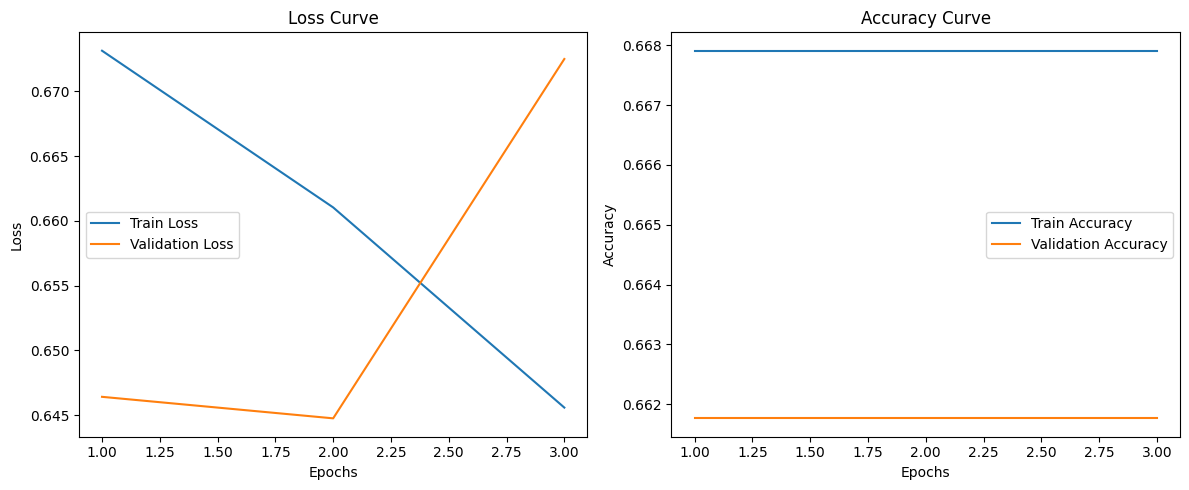

In [23]:

# --- Plot Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

Evaluating model on Validation Set...
Loaded best model weights from /kaggle/working/preprocessed_luna/candidate_detection_model_best.pth


/tmp/ipykernel_31/1505401168.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))


Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Final Validation Loss: 0.6448
Final Validation Accuracy: 0.6618
Optimal Threshold (Youden's J): 0.3867

Confusion Matrix:
[[20 25]
 [ 6 17]]

Metrics at threshold 0.3867:
  Sensitivity (Recall): 0.7391
  Specificity:          0.4444
  Precision:            0.4048
  F1-Score:             0.5231
  AUC-ROC:              0.5266


/tmp/ipykernel_31/2584085783.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


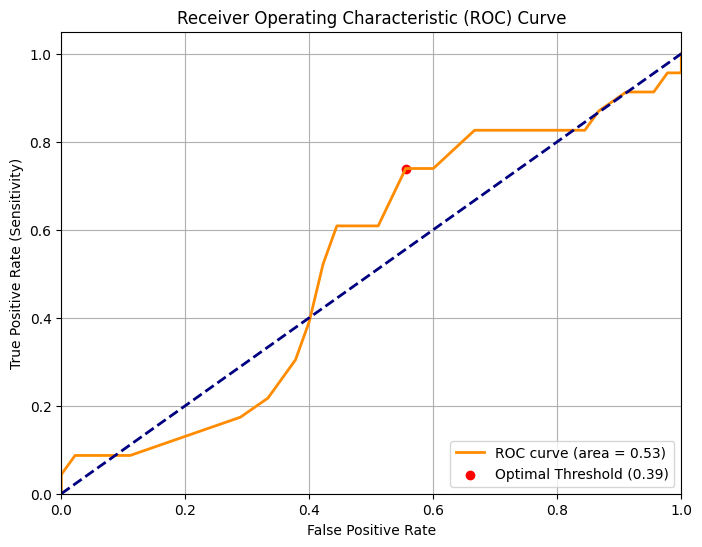

In [24]:

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

print("Evaluating model on Validation Set...")

# Load the best saved model
best_model_path = os.path.join(PREPROCESSED_DATA_PATH, "candidate_detection_model_best.pth")
if os.path.exists(best_model_path):
    try:
        model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
        print(f"Loaded best model weights from {best_model_path}")
    except Exception as e:
        print(f"Could not load best model weights: {e}. Using the model from the last epoch.")
else:
    print("Best model file not found. Using the model from the last epoch.")


val_loss, val_acc, val_labels, val_preds_proba = validate(model, val_loader, criterion, DEVICE)

print(f"\nFinal Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

# Determine optimal threshold from ROC curve (Youden's J statistic) or set manually
fpr, tpr, thresholds = roc_curve(val_labels, val_preds_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Using the optimal threshold for classification metrics
val_preds_binary = (val_preds_proba >= optimal_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds_binary)
print("\nConfusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()

# Metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
auc_roc = roc_auc_score(val_labels, val_preds_proba)

print(f"\nMetrics at threshold {optimal_threshold:.4f}:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Precision:            {precision:.4f}")
print(f"  F1-Score:             {f1_score:.4f}")
print(f"  AUC-ROC:              {auc_roc:.4f}")


# --- Plot ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Visualization Examples ---

True Positives (Correctly detected nodules):


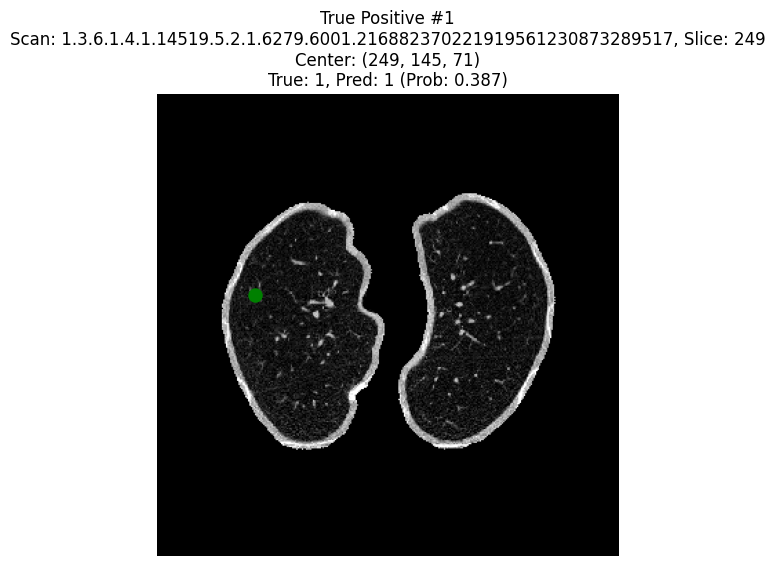

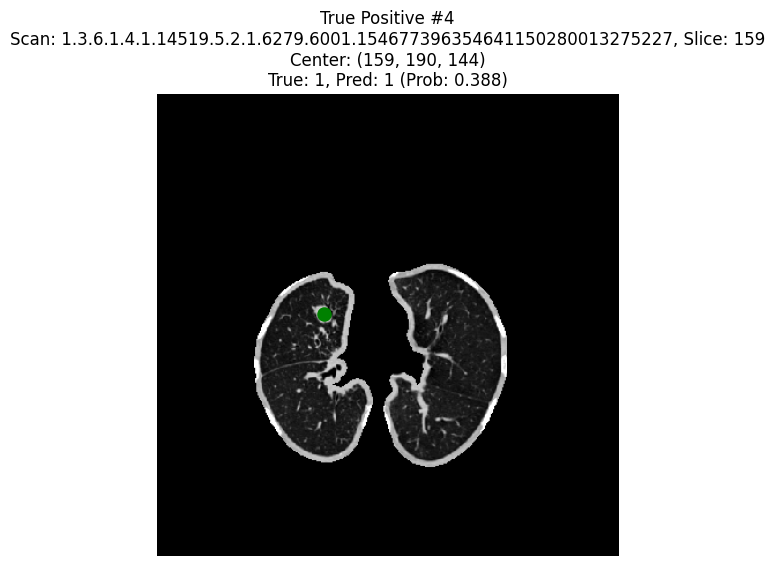

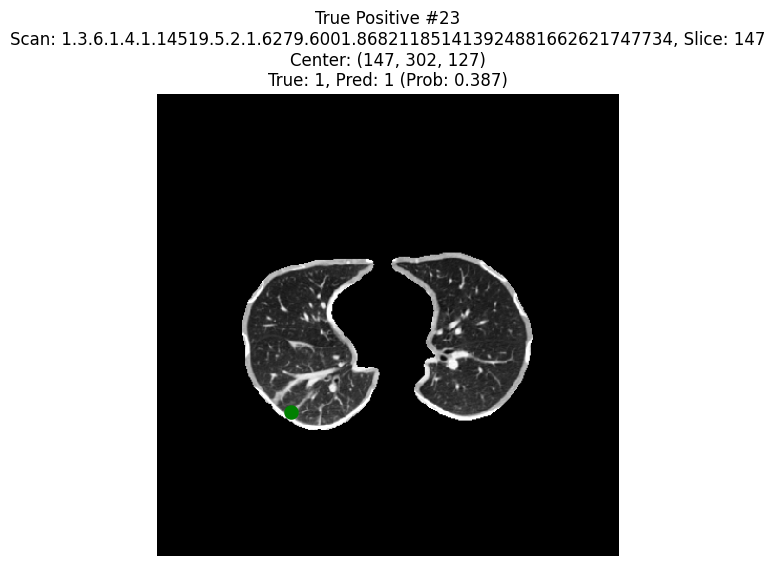

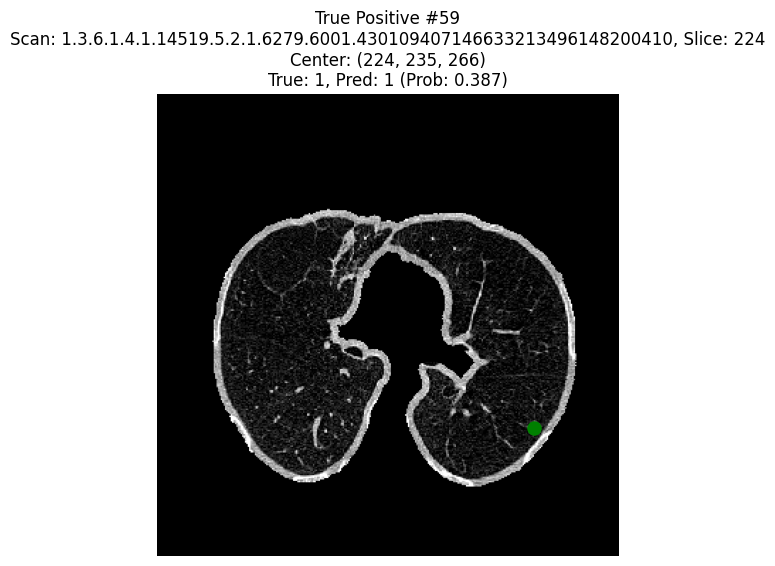

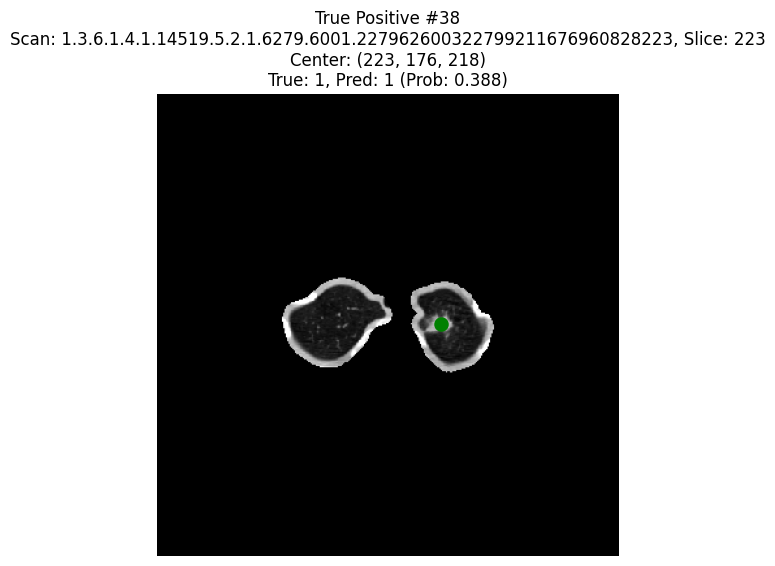


False Positives (Detected as nodule, but isn't):


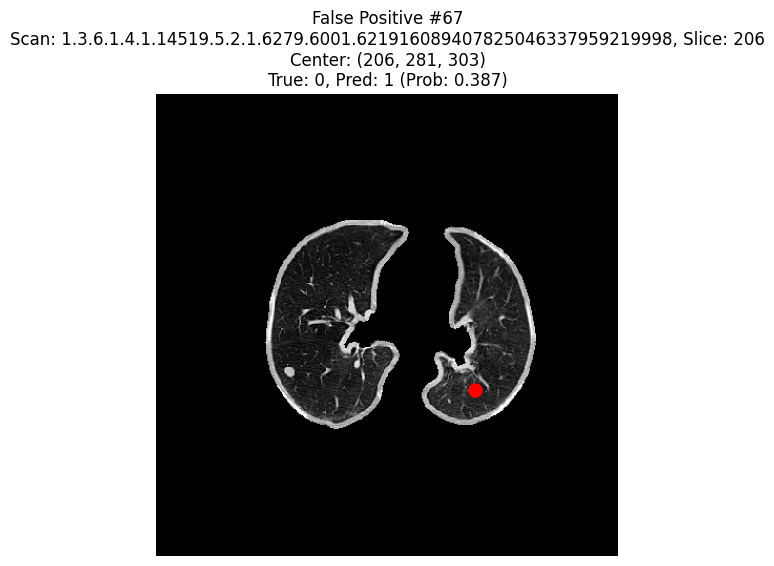

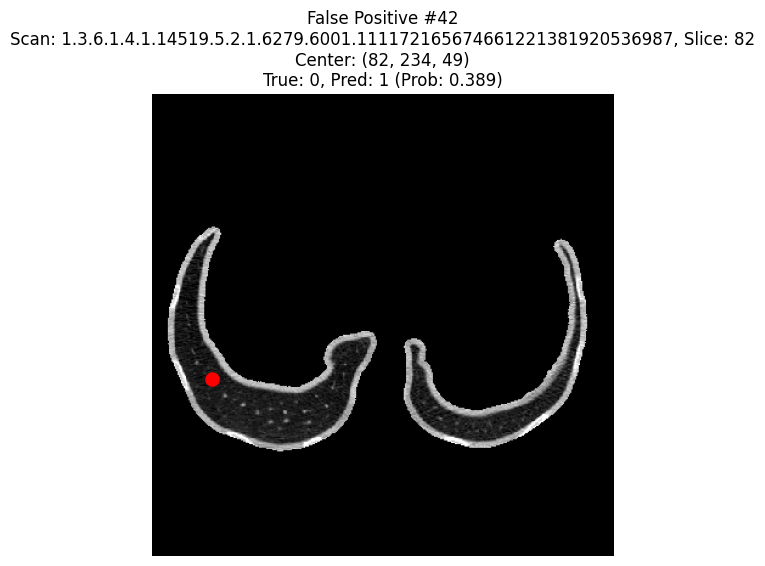

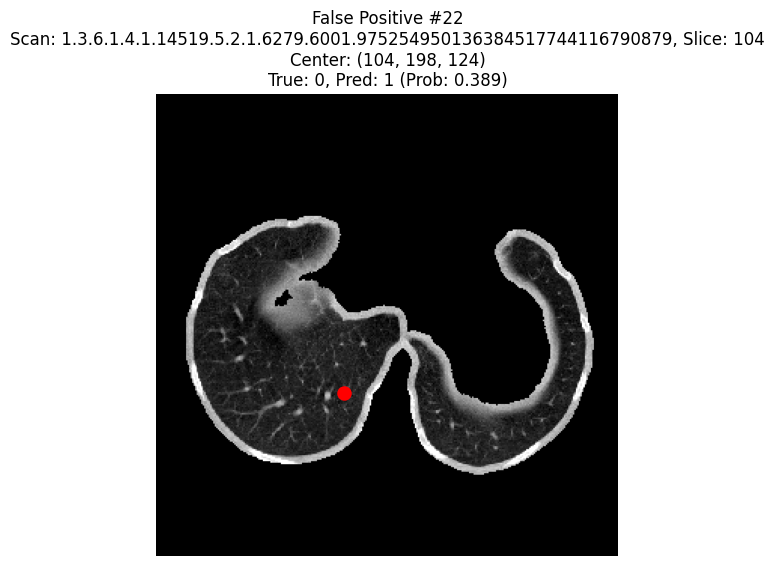

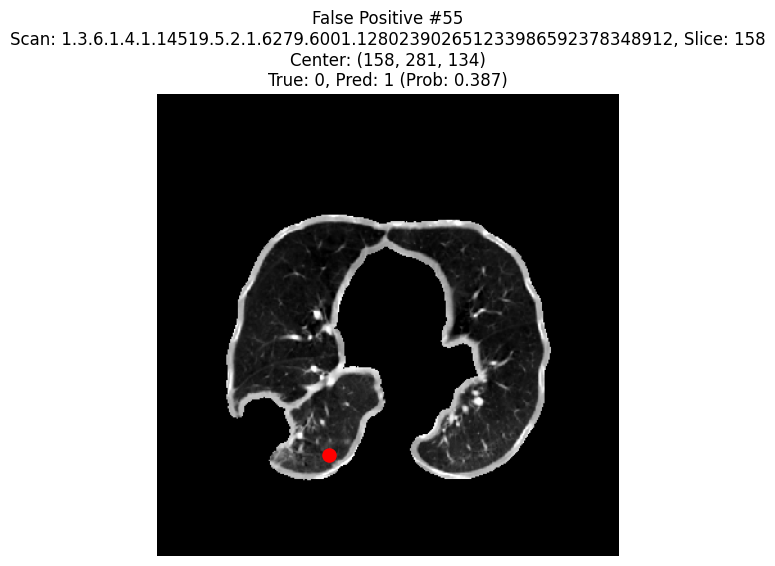

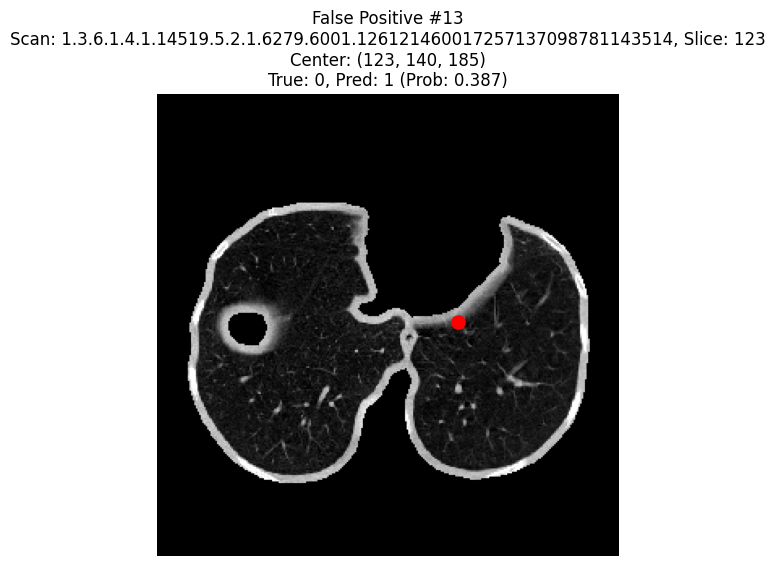


False Negatives (Nodule missed):


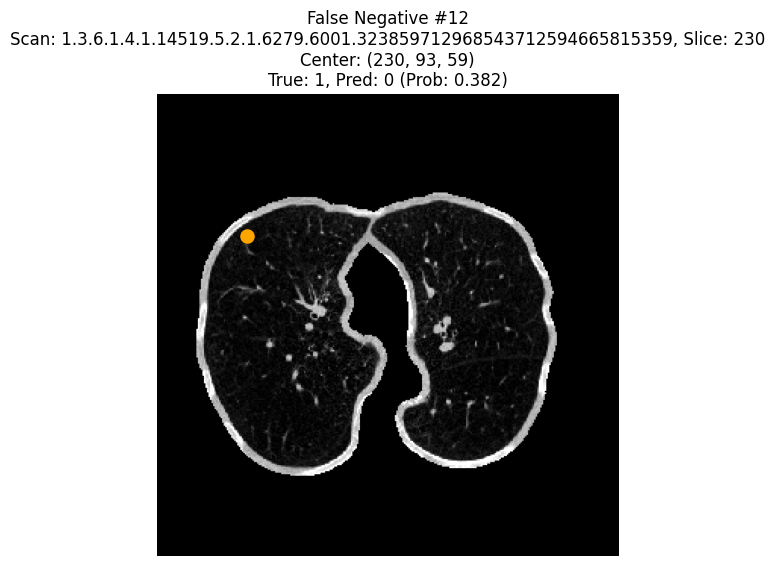

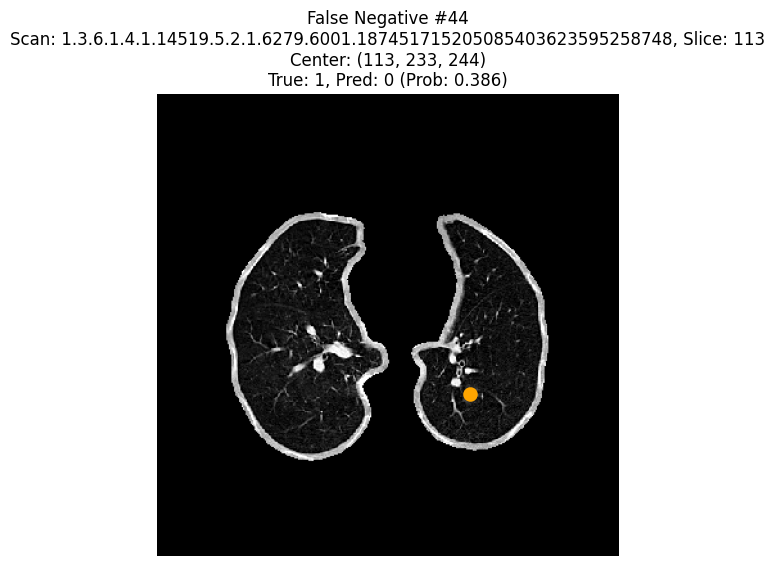

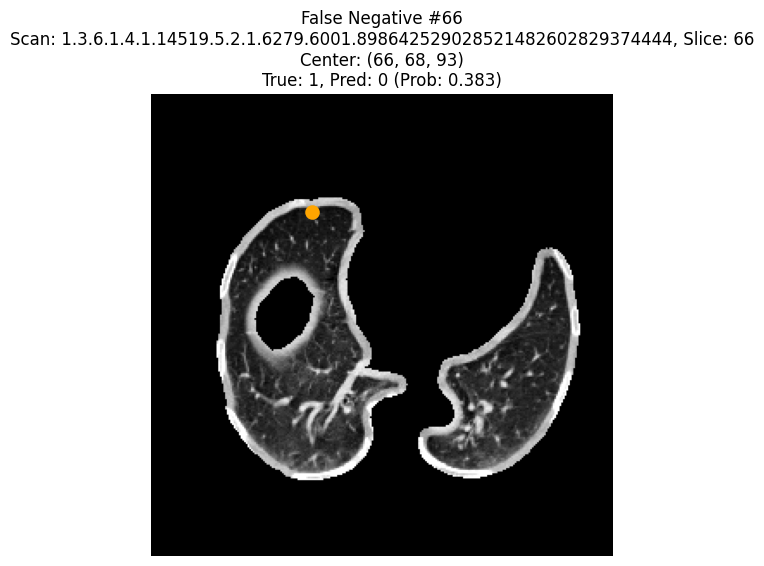

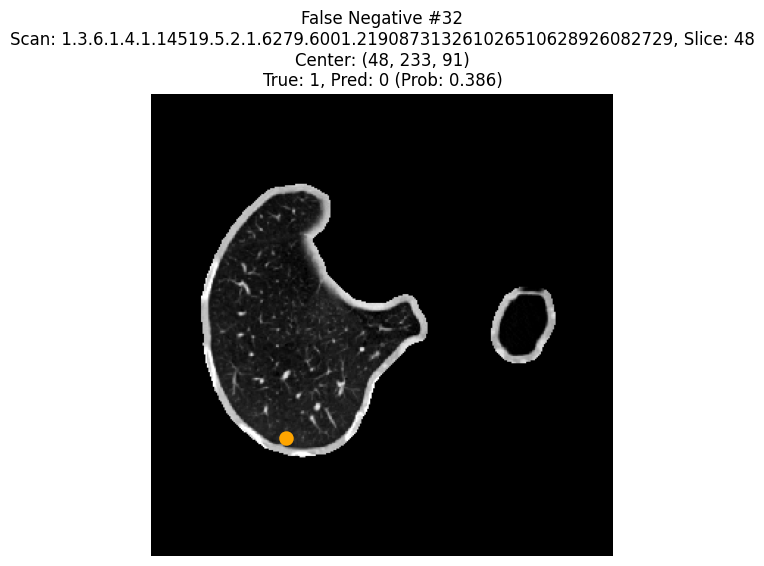

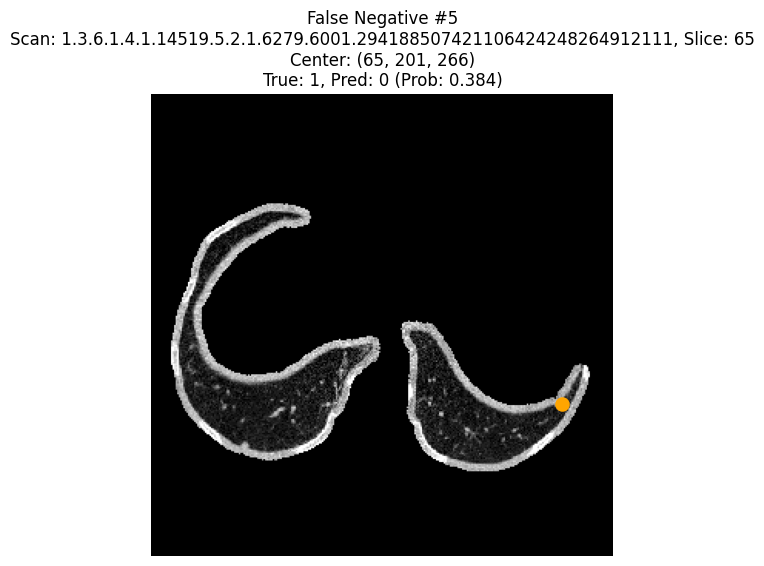

In [25]:

# ## 10. Visualization of Predictions
#
# Visualize some example predictions (True Positives, False Positives, False Negatives) on CT slices.

# In[9]:


def plot_prediction_examples(val_dataset, labels, preds_proba, threshold, processed_scan_data, num_examples=5):
    """Plots example slices with ground truth and prediction."""
    labels = labels.astype(int)
    preds_binary = (preds_proba >= threshold).astype(int)

    tp_indices = np.where((labels == 1) & (preds_binary == 1))[0]
    fp_indices = np.where((labels == 0) & (preds_binary == 1))[0]
    fn_indices = np.where((labels == 1) & (preds_binary == 0))[0]

    def plot_slice(idx, title_prefix):
        candidate_info = val_dataset.candidates_info[idx]
        seriesuid = candidate_info['seriesuid']
        center_voxel = candidate_info['voxel_coord'] # z, y, x
        label = candidate_info['label']
        pred_prob = preds_proba[idx]
        pred_label = (pred_prob >= threshold)

        # Load the corresponding scan slice
        scan_path = processed_scan_data[seriesuid]['path']
        try:
            image = np.load(scan_path)['image']
            slice_idx = center_voxel[0] # z-slice index
            slice_img = image[slice_idx, :, :]

            plt.figure(figsize=(6, 6))
            plt.imshow(slice_img, cmap='gray') # Use gray cmap for better contrast after normalization

            # Mark center - adjust marker based on true/predicted label
            marker_color = 'g' # Green for TP
            if label == 1 and pred_label == 0: marker_color = 'orange' # Orange for FN
            if label == 0 and pred_label == 1: marker_color = 'r' # Red for FP

            plt.scatter(center_voxel[2], center_voxel[1], c=marker_color, marker='o', s=80, facecolors='none', edgecolors=marker_color, linewidth=1.5)
            plt.title(f"{title_prefix} #{idx}\nScan: {seriesuid}, Slice: {slice_idx}\nCenter: {center_voxel}\nTrue: {label}, Pred: {int(pred_label)} (Prob: {pred_prob:.3f})")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error plotting example {idx} (Series: {seriesuid}): {e}")

    print("\n--- Visualization Examples ---")
    print("\nTrue Positives (Correctly detected nodules):")
    for i in np.random.choice(tp_indices, min(num_examples, len(tp_indices)), replace=False):
        plot_slice(i, "True Positive")

    print("\nFalse Positives (Detected as nodule, but isn't):")
    for i in np.random.choice(fp_indices, min(num_examples, len(fp_indices)), replace=False):
        plot_slice(i, "False Positive")

    print("\nFalse Negatives (Nodule missed):")
    for i in np.random.choice(fn_indices, min(num_examples, len(fn_indices)), replace=False):
        plot_slice(i, "False Negative")

# Run visualization (using the validation dataset instances)
# Make sure val_dataset is accessible here
if 'val_dataset' in locals() and 'processed_scan_data' in locals():
     plot_prediction_examples(val_dataset, val_labels, val_preds_proba, optimal_threshold, processed_scan_data)
else:
     print("Validation dataset or processed scan data not available for visualization.")